In [44]:
%reload_ext autoreload
%autoreload 1
%aimport experiment
%aimport utils
%aimport models.xai_models
%aimport helper
%aimport dataloader

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from sklearn.metrics import roc_auc_score, roc_curve

import utils
import ecg_processing
from models.inception1d import Inception1d
from models.xai_models import *
import helper
from dataloader import *

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
experiment_id = '20250602_01_inception_manual'
output_folder = '../myoutput/'
task = 'superdiagnostic'
preprocessor_code = 'basic'
task_type = 'multilabel'
num_classes = 5
sampling_freq = 100
signal_length = 1000
batch_size = 32
num_epochs = 50

In [47]:
# Initialize the model and load the trained weights
model = Inception1d(
	num_classes=num_classes,
	input_channels=12,
	use_residual=True,
	ps_head=0.5,
	lin_ftrs_head=[128],
	kernel_size=40
	)
print(model)

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [48]:
from torchsummary import summary
summary(model, input_size=(12,signal_length), device='cpu')
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1000]             384
            Conv1d-2             [-1, 32, 1000]          39,936
            Conv1d-3             [-1, 32, 1000]          19,456
            Conv1d-4             [-1, 32, 1000]           9,216
         MaxPool1d-5             [-1, 12, 1000]               0
            Conv1d-6             [-1, 32, 1000]             384
       BatchNorm1d-7            [-1, 128, 1000]             256
              ReLU-8            [-1, 128, 1000]               0
  InceptionBlock1d-9            [-1, 128, 1000]               0
           Conv1d-10             [-1, 32, 1000]           4,096
           Conv1d-11             [-1, 32, 1000]          39,936
           Conv1d-12             [-1, 32, 1000]          19,456
           Conv1d-13             [-1, 32, 1000]           9,216
        MaxPool1d-14            [-1, 12

In [49]:
# create dataloaders
resize_len = None if sampling_freq*10 == signal_length else signal_length
loader_train = create_PTBXL_dataloader(sampling_freq, task, 'train', batch_size=batch_size, resize_len=resize_len)
loader_val = create_PTBXL_dataloader(sampling_freq, task, 'val', batch_size=batch_size, resize_len=resize_len)
loader_test = create_PTBXL_dataloader(sampling_freq, task, 'test', batch_size=batch_size, resize_len=resize_len)

In [50]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [51]:
# create output folder
experiment_folder = os.path.join(output_folder, experiment_id)
helper.check_create_folder(experiment_folder)

# save model weights
torch.save(model.state_dict(), os.path.join(experiment_folder, 'initial_weights.pth'))

In [52]:
print(experiment_folder)

../myoutput/20250602_01_inception_manual


In [53]:
# function to save checkpoint
def save_checkpoint(state, filename, folder_path=os.path.join(experiment_folder, 'checkpoints')):
	helper.check_create_folder(folder_path)
	torch.save(state, os.path.join(folder_path, filename))

In [54]:
# training loop

train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_path = os.path.join(experiment_folder, 'best_model.pth')

for epoch in range(num_epochs):
	# training
	model.train()
	train_loss = 0.0

	loader_train_tqdm = tqdm(loader_train, desc=f'{epoch+1}/{num_epochs} [Train]', leave=True, unit='batch')

	for i, batch in enumerate(loader_train_tqdm):
		inputs, labels = [x.to(device, non_blocking=True) for x in batch]

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, labels)
		with torch.autograd.set_detect_anomaly(True):
			loss.backward()
		optimizer.step()

		train_loss += loss.item()
		loader_train_tqdm.set_postfix({'avg_train_loss':train_loss/(i+1)})

	avg_train_loss = train_loss / len(loader_train)
	train_losses.append(avg_train_loss)

	# validation
	model.eval()
	val_loss = 0.0
	loader_val_tqdm = tqdm(loader_val, desc=f'{epoch+1}/{num_epochs} [Val]  ', leave=True, unit='batch')
	with torch.no_grad():
		for i, batch in enumerate(loader_val_tqdm):
			inputs, labels = [x.to(device) for x in batch]

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			val_loss += loss.item()
			loader_val_tqdm.set_postfix({'\t\tavg_val_loss':val_loss/(i+1)})

	avg_val_loss = val_loss / len(loader_val)
	val_losses.append(avg_val_loss)

	# save checkpoint every epoch
	checkpoint = {
		'epoch': epoch,
		'model_state_dict': model.state_dict(),
		'optimizer_state_dict': optimizer.state_dict(),
		'train_loss': avg_train_loss,
		'val_loss': avg_val_loss
	}
	save_checkpoint(checkpoint, f'epoch_{epoch+1}')

	# early stopping check
	if avg_val_loss < best_val_loss:
		best_val_loss = avg_val_loss
		patience_counter = 0
		torch.save(model.state_dict(), best_model_path)
	else:
		patience_counter += 1
	if patience_counter >= patience:
		print('Early stopping triggered')
		break

	# tqdm.write(f"train loss: {avg_train_loss:.4f} | val loss: {avg_val_loss:.4f}")

19/50 [Val]  : 100%|██████████| 68/68 [00:03<00:00, 20.71batch/s, 		avg_val_loss=0.27] 


Early stopping triggered


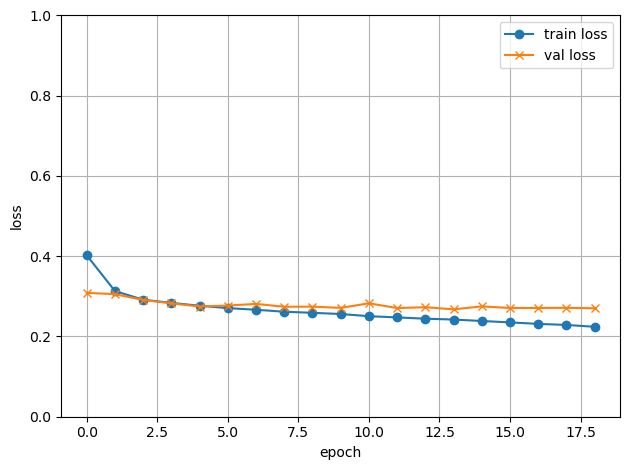

In [59]:
import matplotlib.pyplot as plt

epochs = range(len(val_losses))

plt.figure()
plt.plot(epochs, train_losses, label='train loss', marker='o')
plt.plot(epochs, val_losses, label='val loss', marker='x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# save model weights
torch.save(model.state_dict(), os.path.join(experiment_folder, 'weights.pth'))

# save experiment classes
classes = loader_train.dataset.classes
np.save(os.path.join(experiment_folder, 'classes.npy'), classes)

# save training result
training_result = pd.DataFrame({
	'train_loss':train_losses,
	'val_loss':val_losses
})
training_result.to_csv(os.path.join(experiment_folder, 'training_result.csv'), index=False)

### Evaluate the best model

We reload the best model and run it over test data

In [61]:
# load best model
trained_model = model
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.to(device)
trained_model.eval()

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [62]:
all_labels = []
all_preds = []
result_folder = os.path.join(experiment_folder, 'result')
helper.check_create_folder(result_folder)

with torch.no_grad():
	for inputs, labels in loader_test:
		inputs = inputs.to(device)
		outputs = trained_model(inputs)
		preds = torch.sigmoid(outputs)

		all_labels.append(labels.cpu().numpy())
		all_preds.append(preds.cpu().numpy())

y_test_true = np.concatenate(all_labels)
y_test_pred = np.concatenate(all_preds)

# save true and preds
np.save(os.path.join(result_folder, 'y_test_true.npy'), y_test_true)
np.save(os.path.join(result_folder, 'y_test_pred.npy'), y_test_pred)

ROC AUC score: 0.9288267470166094


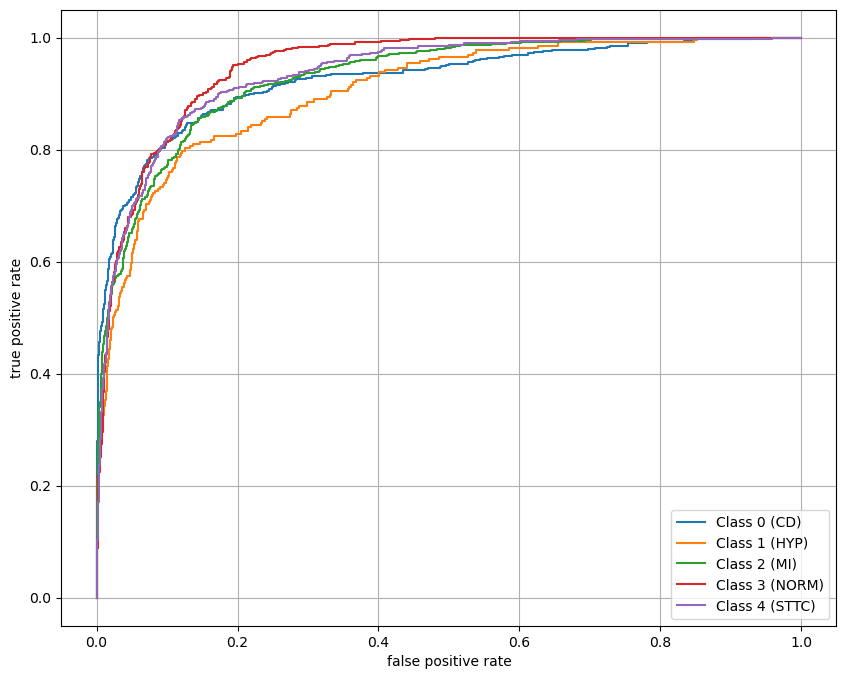

In [71]:
# reload predictions
y_test_true = np.load(os.path.join(result_folder, 'y_test_true.npy'))
y_test_pred = np.load(os.path.join(result_folder, 'y_test_pred.npy'))

# reload class names
classes = np.load(os.path.join(experiment_folder, 'classes.npy'), allow_pickle=True)

score = None
if task_type == 'multilabel':
	score = roc_auc_score(y_test_true, y_test_pred, average='macro')
elif task_type == 'binary':
	score = roc_auc_score(y_test_true, y_test_pred)

print(f'ROC AUC score: {score}')

# plot ROC curve
if task_type == 'multilabel':
	n_classes = y_test_pred.shape[1]
	plt.figure(figsize=(10,8))
	plt.grid(True)
	plt.xlabel('false positive rate')
	plt.ylabel('true positive rate')
	for i in range(n_classes):
		fpr, tpr, _ = roc_curve(y_test_true[:, i], y_test_pred[:,i])

		plt.plot(fpr, tpr, label=f'Class {i} ({classes[i]})')
	
	plt.legend(loc='lower right')
	plt.show()